In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder & filename if different
df = pd.read_csv(file_path)

# ========== Stratified Split (70% Train, 15% Val, 15% Test) ==========
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# ========== Save Split Data (Kaggle uses `/kaggle/working` for output) ==========
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
val_df.to_csv("/kaggle/working/val_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# ========== Summary Table ==========
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# ========== Save Summary Table ==========
split_summary.to_csv("/kaggle/working/split_summary.csv")

# ========== Display ==========
print("\nData Split Summary:\n", split_summary)
print("\n✅ Data split completed and saved to `/kaggle/working/`.")



Data Split Summary:
 Binary_class      Non-Damage  Damage
Train (70%)            10853    1804
Validation (15%)        2326     386
Test (15%)              2326     387
Total                  15505    2577

✅ Data split completed and saved to `/kaggle/working/`.


Before SMOTE: [10853  1804]
After SMOTE: [10853 10853]
Epoch 1/10
340/340 - 6s - 18ms/step - accuracy: 0.8552 - loss: 0.3337 - val_accuracy: 0.8772 - val_loss: 0.3419
Epoch 2/10
340/340 - 1s - 2ms/step - accuracy: 0.9658 - loss: 0.1015 - val_accuracy: 0.8909 - val_loss: 0.4613
Epoch 3/10
340/340 - 1s - 2ms/step - accuracy: 0.9873 - loss: 0.0400 - val_accuracy: 0.8820 - val_loss: 0.5823
Epoch 4/10
340/340 - 1s - 2ms/step - accuracy: 0.9930 - loss: 0.0226 - val_accuracy: 0.8901 - val_loss: 0.6569
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Train Accuracy: 0.9671058693448816
Train ROC-AUC: 0.9923034306605205
Train Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     10853
           1       0.96      0.97      0.97     10853

    accuracy                           0.97     21706
   macro avg       0.97      0.97      0.97     21706
weighted avg       0.97      0.97      0.97    

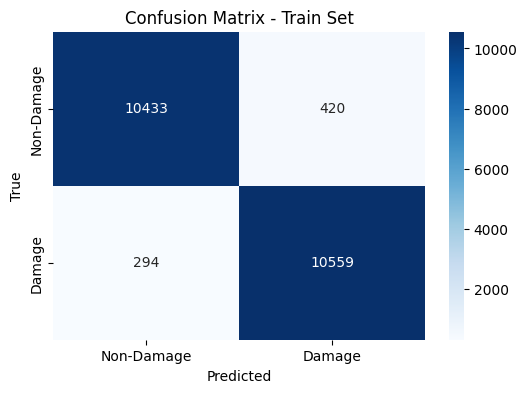

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load dataset from Kaggle paths
train_df = pd.read_csv("/kaggle/working/train_data.csv")
val_df = pd.read_csv("/kaggle/working/val_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# Preprocess labels
label_map = {'damage': 1, 'non-damage': 0}
train_df['Binary_class'] = train_df['Binary_class'].str.strip().str.lower().map(label_map)
val_df['Binary_class'] = val_df['Binary_class'].str.strip().str.lower().map(label_map)
test_df['Binary_class'] = test_df['Binary_class'].str.strip().str.lower().map(label_map)

# Fill missing values
train_df['Processed_data'] = train_df['Processed_data'].fillna("")
val_df['Processed_data'] = val_df['Processed_data'].fillna("")
test_df['Processed_data'] = test_df['Processed_data'].fillna("")

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['Processed_data']).toarray()
X_val = vectorizer.transform(val_df['Processed_data']).toarray()
X_test = vectorizer.transform(test_df['Processed_data']).toarray()

y_train = train_df['Binary_class'].values
y_val = val_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# SMOTE for balancing
print("Before SMOTE:", np.bincount(y_train))
smote = SMOTE(random_state=42, sampling_strategy=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_smote))

# CNN model for binary classification
model = Sequential([
    Input(shape=(X_train_smote.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

# Evaluate on training set
train_preds = (model.predict(X_train_smote) > 0.5).astype(int)
train_proba = model.predict(X_train_smote)
train_acc = accuracy_score(y_train_smote, train_preds)
train_roc = roc_auc_score(y_train_smote, train_proba)
train_report = classification_report(y_train_smote, train_preds)

print("Train Accuracy:", train_acc)
print("Train ROC-AUC:", train_roc)
print("Train Classification Report:\n", train_report)

# Confusion matrix
cm = confusion_matrix(y_train_smote, train_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Train Set")
plt.show()
